<a href="https://colab.research.google.com/github/2403A51L47/AIML_2025/blob/main/regression_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS
from sklearn.decomposition import KernelPCA, FactorAnalysis, FastICA, NMF, PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

In [4]:
tips = pd.read_csv("tips.csv")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [5]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [6]:
tips.dropna(inplace=True)

In [7]:
categorical_cols = tips.select_dtypes(exclude=['number']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    tips[col] = le.fit_transform(tips[col])
    label_encoders[col] = le
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,2,0,2
1,10.34,1.66,1,0,2,0,3
2,21.01,3.50,1,0,2,0,3
3,23.68,3.31,1,0,2,0,2
4,24.59,3.61,0,0,2,0,4
...,...,...,...,...,...,...,...
239,29.03,5.92,1,0,1,0,3
240,27.18,2.00,0,1,1,0,2
241,22.67,2.00,1,1,1,0,2
242,17.82,1.75,1,0,1,0,2


In [8]:
X = tips.drop(columns=["tip"])
Y = tips['tip']

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
def plot_clustering(X, Y, feature_name=None):
    clustering_algorithms = {
        "KMeans": KMeans(n_clusters=3, random_state=42),
        "Agglomerative": AgglomerativeClustering(n_clusters=3),
        "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
        "Spectral": SpectralClustering(n_clusters=3, random_state=42),
        "GaussianMixture": GaussianMixture(n_components=3, random_state=42)
    }

    if feature_name:
        if feature_name in X.columns:
            features = [feature_name]
        else:
            print(f"Feature '{feature_name}' not found in dataset. Using all features.")
            features = X.columns
    else:
        features = X.columns

    plt.figure(figsize=(15, 10))
    for i, (name, model) in enumerate(clustering_algorithms.items()):
        try:
            clusters = model.fit_predict(X)
            plt.subplot(2, 3, i + 1)
            if len(features) == 1:
                plt.scatter(X[features[0]], Y, c=clusters, cmap='viridis', alpha=0.6)
                plt.xlabel(features[0])
            else:
                plt.scatter(X.iloc[:, 0], Y, c=clusters, cmap='viridis', alpha=0.6)
                plt.xlabel(X.columns[0])
            plt.ylabel("Tip Amount")
            plt.title(f"{name} Clustering")
        except Exception as e:
            print(f"Error in {name}: {e}")
    plt.tight_layout()
    plt.show()

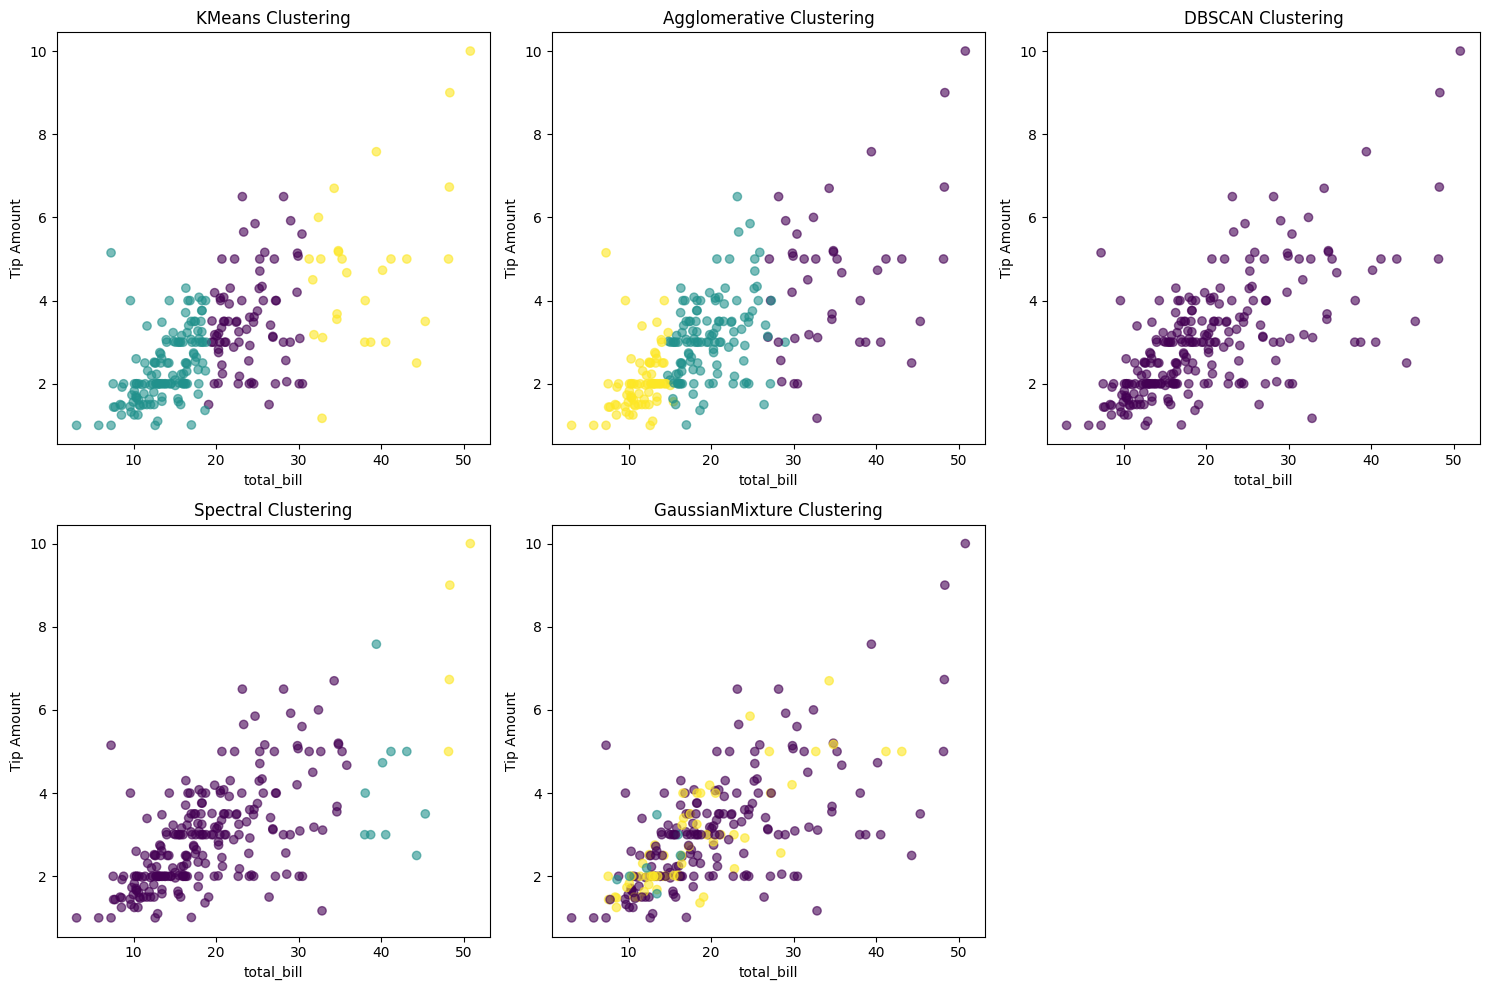

In [11]:
plot_clustering(X, Y, feature_name="total_bill")

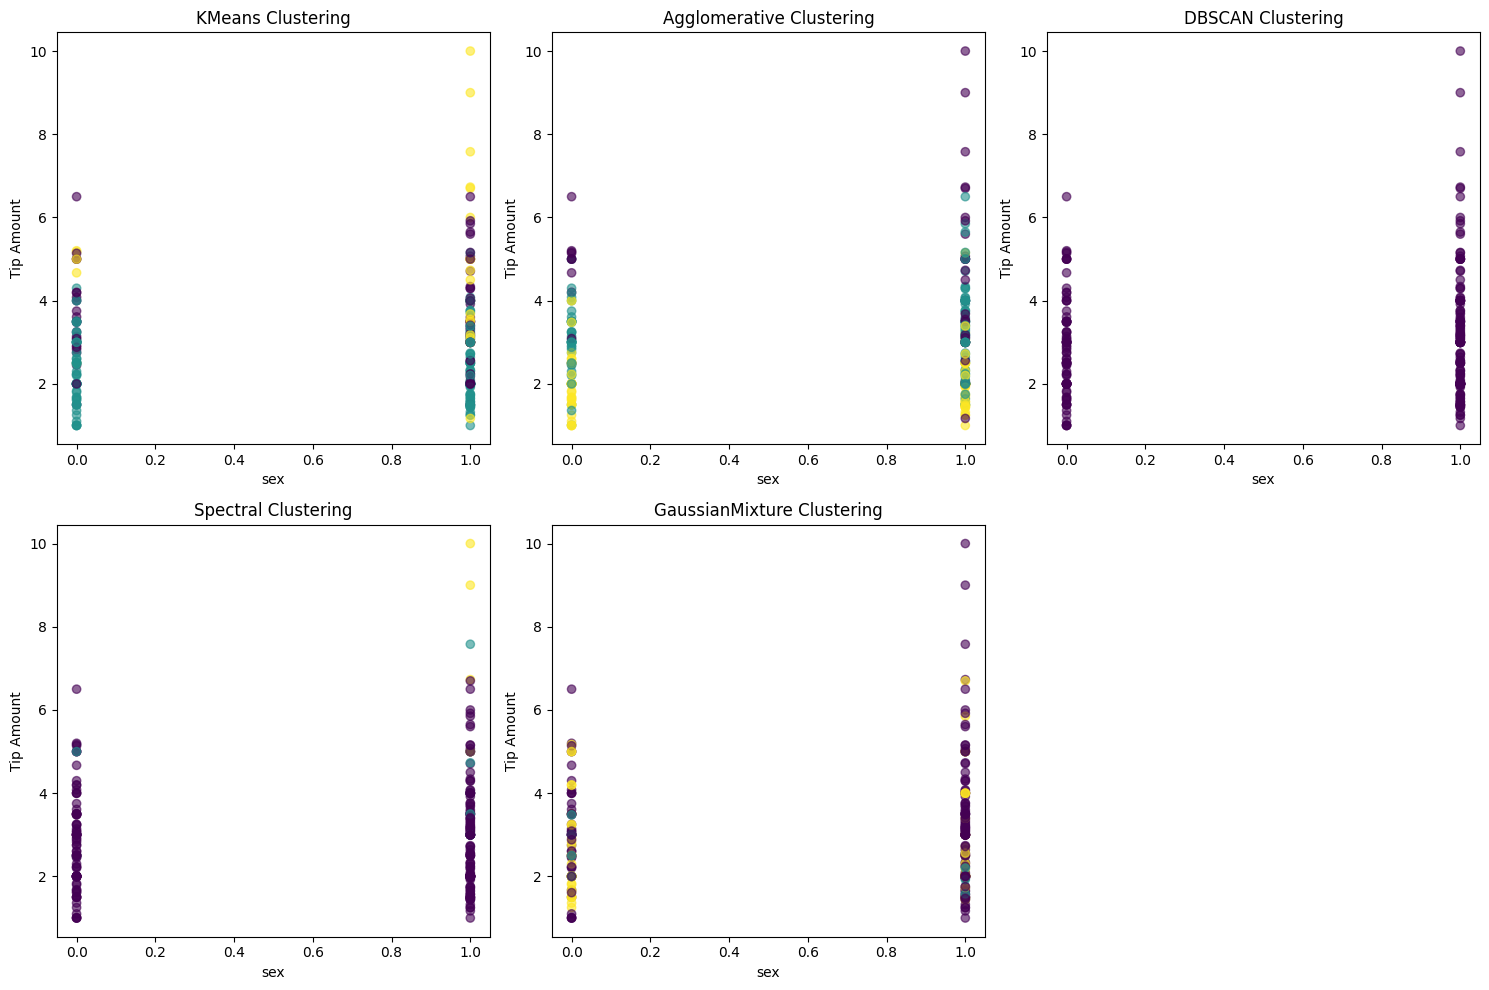

In [12]:
plot_clustering(X, Y, feature_name="sex")

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


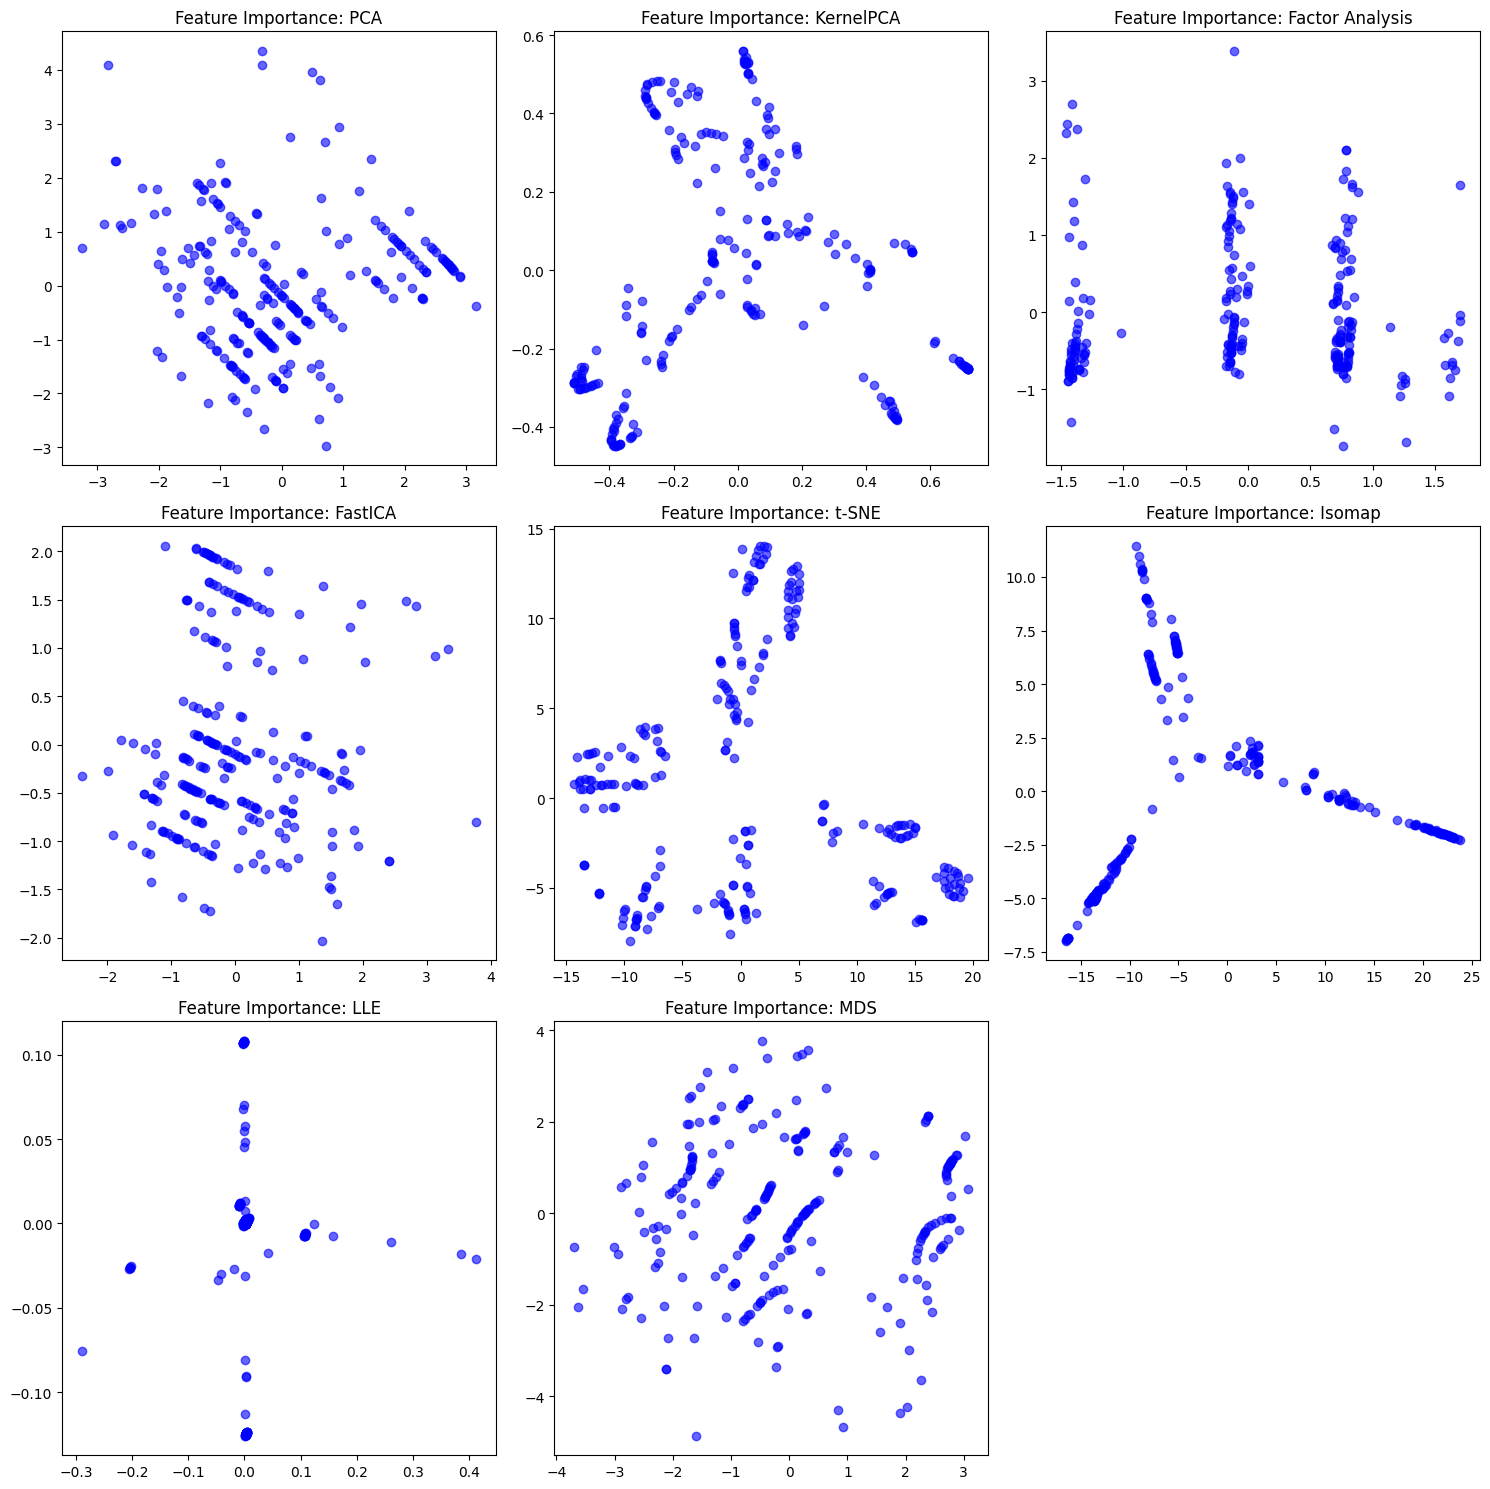

In [13]:
dim_reduction_methods = {
    "PCA": PCA(n_components=2),
    "KernelPCA": KernelPCA(n_components=2, kernel='rbf'),
    "Factor Analysis": FactorAnalysis(n_components=2),
    "FastICA": FastICA(n_components=2),
    "t-SNE": TSNE(n_components=2, random_state=42),
    "Isomap": Isomap(n_components=2),
    "LLE": LocallyLinearEmbedding(n_components=2),
    "MDS": MDS(n_components=2),
}

plt.figure(figsize=(15, 15))
for i, (name, model) in enumerate(dim_reduction_methods.items(), 1):
    X_reduced = model.fit_transform(X_scaled)
    plt.subplot(3, 3, i)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.6, color='blue')
    plt.title(f"Feature Importance: {name}")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:736: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:756: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))


<Figure size 640x480 with 0 Axes>

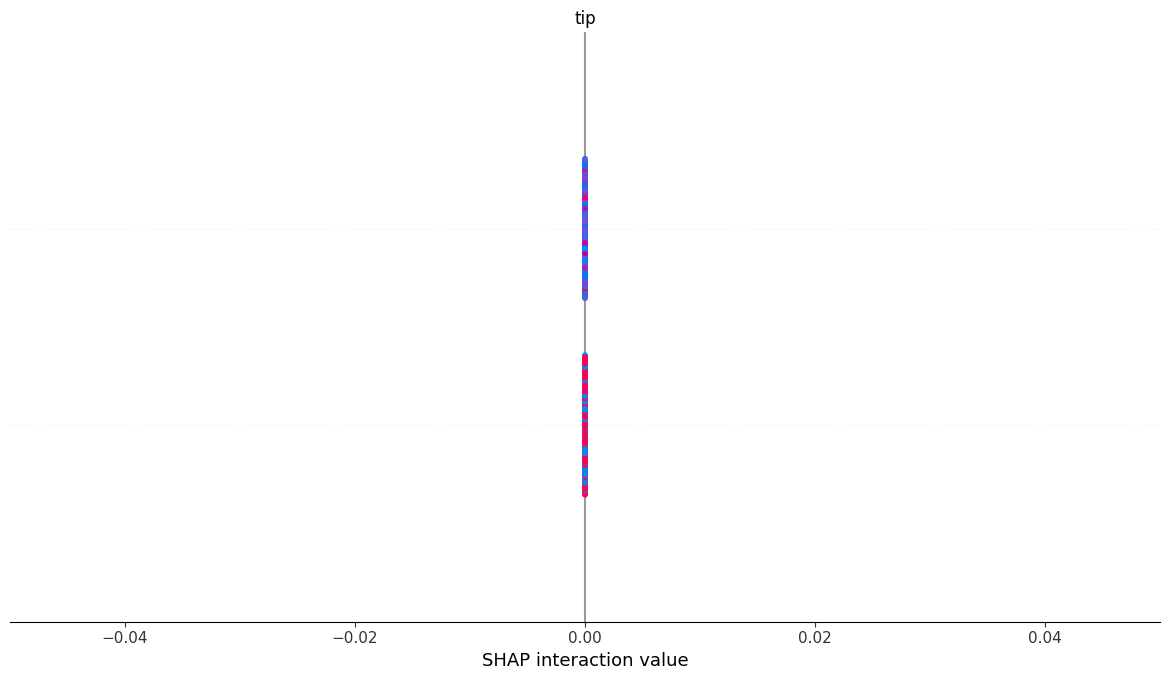

In [17]:
explainer = shap.Explainer(lambda x: np.zeros((x.shape[0], 2)), X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, feature_names=tips.columns[:-1])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


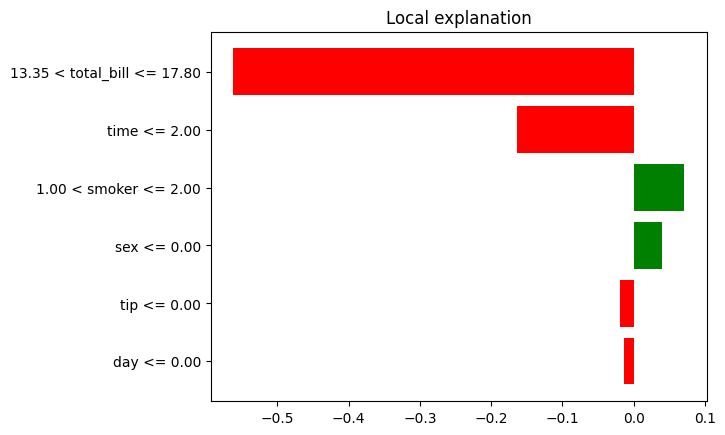

In [18]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X, Y)
explainer = LimeTabularExplainer(X.values, feature_names=tips.columns[:-1], mode="regression")
exp = explainer.explain_instance(X.values[0], clf.predict)
exp.as_pyplot_figure()
plt.show()